# Análise comparativa

In [1]:
# import libraries

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pickle

## 1. Coleta de dados

In [2]:
def loading_data():
    return pd.read_csv('../data/processed/exercise.csv')

dictionary = pd.read_csv('../data/external/dictionary.csv')

df = loading_data()
df

,id,diet,pulse,time,kind
0,1,low fat,85,1,rest
1,1,low fat,85,15,rest
2,1,low fat,88,30,rest
3,2,low fat,90,1,rest
4,2,low fat,92,15,rest
...,...,...,...,...,...
85,29,no fat,135,15,running
86,29,no fat,130,30,running
87,30,no fat,99,1,running
88,30,no fat,111,15,running


## 2. Processamento de dados faltantes
Verificando a estatística descritiva e a qutde de dados faltantes

In [3]:
pd.concat([df.isnull().sum(), display(df[['pulse', 'time']].describe())], axis=1).T

,pulse,time
count,90.000000,90.000000
mean,99.700000,15.333333
std,14.858471,11.907886
min,80.000000,1.000000
25%,90.250000,1.000000
50%,96.000000,15.000000
75%,103.000000,30.000000
max,150.000000,30.000000


,id,diet,pulse,time,kind
0,0,0,0,0,0


In [4]:
mean = df[['pulse', 'time']].mean()
std = df[['pulse', 'time']].std()

O dataset não possui dados faltantes, para fins educativo, será imputado dados faltantes na função abaixo

In [5]:
def impute_missing_data():
    df = loading_data()
    if df.isnull().sum().sum() == 0:
        display('No missing values, entering...')
        missing_rate = .4
        columns = ['pulse', 'time']
        for column in columns:
            missing_rows = np.random.choice(
                range(df.shape[0]),
                size=int(df.shape[0] * missing_rate),
                replace=False
            )
            df.loc[missing_rows, column] = np.NaN
    return df.isnull().sum(), df

_, df = impute_missing_data()
df = df

'No missing values, entering...'

Simulação de remoção de linhas e colunas

In [6]:
print('removing lines: ', df.dropna().shape)
print('removing columns: ', df.dropna(axis=1).shape)

removing lines:  (32, 5)
removing columns:  (90, 3)


Dados faltantes inclusos nas colunas (pulse, time)

In [7]:
df[['pulse', 'time']]

,pulse,time
0,85.0,NaN
1,NaN,15.0
2,88.0,30.0
3,90.0,1.0
4,92.0,NaN
...,...,...
85,135.0,15.0
86,130.0,30.0
87,99.0,NaN
88,NaN,15.0


In [8]:
qualitative_variables = (
    dictionary
    .query("tipo == 'qualitativa'")
    .variavel
    .to_list()
)
quantitative_variables = (
    dictionary
    .query("tipo == 'quantitativa'")
    .variavel
    .to_list()
)
quantitative_variables.remove('id')
qualitative_variables + ['-'] + quantitative_variables

['diet', 'kind', '-', 'pulse', 'time']

### Imputador `Simple Imputer`

In [9]:
simple_imputer = SimpleImputer(strategy='most_frequent')
simple_imputer.fit(df[quantitative_variables])
df2 = simple_imputer.transform(df[quantitative_variables])

print(mean[0],mean[1], std[0],std[1])
print(df2.mean(axis=0), df2.std(axis=0))

99.7 15.333333333333334 14.858470893849434 11.907886160397602
[95.83333333  9.46666667] [12.65811115 11.97979781]


### Imputador `KNN Imputer`

In [10]:
_, df = impute_missing_data()

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(df[quantitative_variables])
df3 = knn_imputer.transform(df[quantitative_variables])

print(mean[0],mean[1], std[0],std[1])
print(df3.mean(axis=0), df3.std(axis=0))

'No missing values, entering...'

99.7 15.333333333333334 14.858470893849434 11.907886160397602
[97.41497942 17.44625514] [11.23742593  8.74873055]


### Imputador `Iterative Imputer`

In [11]:
_, df = impute_missing_data()

iterative_imputer = IterativeImputer(estimator=LinearRegression()) 
iterative_imputer.fit(df[quantitative_variables])
df4 = iterative_imputer.transform(df[quantitative_variables])

print(mean[0],mean[1], std[0],std[1])
print(df4.mean(axis=0), df4.std(axis=0))

'No missing values, entering...'

99.7 15.333333333333334 14.858470893849434 11.907886160397602
[100.51214911  16.03115312] [11.14101386  9.23339249]


## 3. Processamento de dados discrepantes
Verificando a correlação entre as variáveis quantitativas

<Axes: >

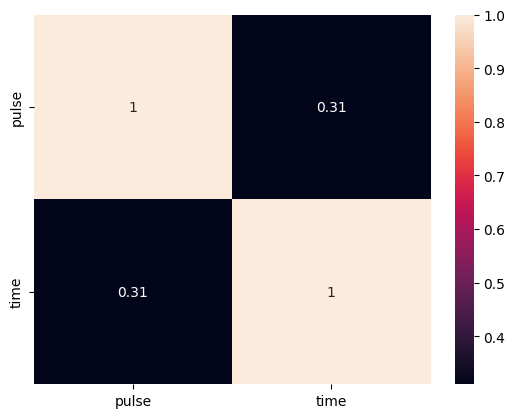

In [12]:
df = loading_data()
sns.heatmap(df[['pulse', 'time']].corr(),annot=True)

Distribuição das variáveis quantitativas x (time) e y (pulse)

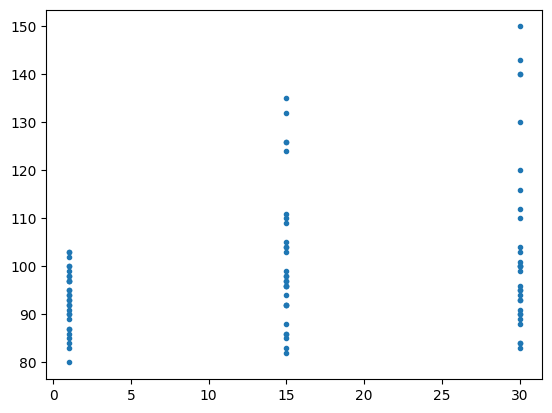

In [13]:
x = df['time'].values
y = df['pulse'].values

plt.plot(x, y, '.')

Entre as variáveis (time, pulse), time possui apenas timepoint (1,15, 30), pulse única variável com possiveis dados discrepantes

In [14]:
y_mean = y.mean()
y_std = y.std()
z_score = np.abs(y - y_mean) / y_std

z_score

array([0.99487718, 0.99487718, 0.79184102, 0.65648358, 0.52112614,
       0.45344742, 0.18273254, 0.18273254, 0.3857687 , 1.33327078,
       1.19791334, 1.13023462, 0.58880486, 0.52112614, 0.58880486,
       1.13023462, 1.13023462, 1.0625559 , 0.85951974, 0.79184102,
       0.65648358, 0.52112614, 0.3857687 , 0.31808998, 0.18273254,
       0.0473751 , 0.25041126, 0.02030362, 0.18273254, 0.02030362,
       0.92719846, 0.92719846, 1.0625559 , 0.45344742, 0.22333977,
       0.29101849, 0.65648358, 0.52112614, 0.45344742, 0.31808998,
       0.25041126, 0.02030362, 0.7241623 , 0.25041126, 0.31808998,
       1.0625559 , 0.92719846, 0.7241623 , 0.22333977, 0.62941209,
       0.65648358, 0.52112614, 0.25041126, 0.08798234, 0.18273254,
       0.11505382, 0.02030362, 0.15566105, 0.29101849, 0.22333977,
       0.45344742, 0.11505382, 0.69709081, 0.11505382, 0.29101849,
       0.83244825, 0.11505382, 0.35869721, 0.0473751 , 0.85951974,
       2.18602264, 1.37387801, 0.3857687 , 0.69709081, 1.10316

In [15]:
x_without_anomalies = x[z_score <= 3]
y_without_anomalies = y[z_score <= 3]

x_without_anomalies.shape, y_without_anomalies.shape

((89,), (89,))

Limpando as anomalias por meio do z-score, apenas um dado com z-score de 3.40423959

In [16]:
df = df[~(y >= y_mean + 3 * y_std) | (y <= y_mean - 3 * y_std)]
df.to_csv('../data/processed/exercise.csv', index=False)
df

,id,diet,pulse,time,kind
0,1,low fat,85,1,rest
1,1,low fat,85,15,rest
2,1,low fat,88,30,rest
3,2,low fat,90,1,rest
4,2,low fat,92,15,rest
...,...,...,...,...,...
84,29,no fat,94,1,running
85,29,no fat,135,15,running
86,29,no fat,130,30,running
87,30,no fat,99,1,running


### 4. Transformação com one-hot
Codificação de variáveis qualitativas (nominais ou ordinais)

In [17]:
target_column = 'diet'
nominal_columns = (
    dictionary.query('subtipo == "nominal" and variavel != @target_column').variavel.to_list()
)
continuous_columns = (
    dictionary.query('subtipo == "contínua"').variavel.to_list()
)
exclude_columns = nominal_columns + continuous_columns + [target_column]

rest_columns = (
    dictionary.query('variavel not in @exclude_columns').variavel.to_list()
)

Divisão entre features e classe

In [27]:
X = df.drop(columns=[target_column], axis=1)
y = df[target_column]
X.shape, X, y, nominal_columns, continuous_columns, rest_columns

((89, 4),
     id  pulse  time     kind
 0    1     85     1     rest
 1    1     85    15     rest
 2    1     88    30     rest
 3    2     90     1     rest
 4    2     92    15     rest
 ..  ..    ...   ...      ...
 84  29     94     1  running
 85  29    135    15  running
 86  29    130    30  running
 87  30     99     1  running
 88  30    111    15  running
 
 [89 rows x 4 columns],
 0     low fat
 1     low fat
 2     low fat
 3     low fat
 4     low fat
        ...   
 84     no fat
 85     no fat
 86     no fat
 87     no fat
 88     no fat
 Name: diet, Length: 89, dtype: object,
 ['kind'],
 ['pulse'],
 ['id', 'time'])

Kind tem 3 tipos (rest, walking e running) e diet (low fat, no fat)

In [19]:
len(np.unique(df['kind'])), len(np.unique(df['diet']))

(3, 2)

Pipeline para imputação, codificação e normalização

In [20]:
nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), 
    ('encoding', OneHotEncoder(sparse_output=False)), 
    ('normalization', StandardScaler()), 
]) 

continuous_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')), 
    ('normalization', StandardScaler()),
])

rest_preprocessor = Pipeline([
    ('missing', SimpleImputer()), 
    ('normalization', StandardScaler()), 
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('continuous', continuous_preprocessor, continuous_columns),
    ('rest', rest_preprocessor, rest_columns),
], remainder='passthrough')

In [28]:
X = preprocessor.fit_transform(X)
pd.DataFrame(X).to_csv('../data/processed/standardized.csv', index=False)

Divisão das bases em treinamento e teste

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.30,
                                                        random_state=0)

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((62, 6), (62,), (27, 6), (27,))

Salvar as variáveis

In [24]:
with open('features-exercise.pkl', mode='wb') as f:
    pickle.dump([X_train, y_train, X_test, y_test], f)